# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods that will be used to get training and validation data loader.

For example,

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics libraries for python

import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision

from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd

from PIL import Image

#from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter


In [3]:
classesArray = [] # hack

class FoodDataset(Dataset):
    """
    This custom dataset class take root directory and train flag, 
    and return dataset training dataset id train flag is true 
    else is return validation dataset.
    """
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         train (boolean): True for training dataset and False for test dataset.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             It is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transforms it.
         
        """
        
        # get label to class mapping
        if train:
            label_csv_path = os.path.join(data_root, 'train.csv')
        else:
            label_csv_path = os.path.join(data_root, 'sample_submission.csv') # sample_submission.csv? test.csv does not have classes...
        
        img_dir = os.path.join(data_root, 'images', 'images')
        
        self.label_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
        
        # set transform attribute
        self.transform = transform
        
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        # Maybe train_test_split from sklearn would be a better option
        for i, table in self.label_df.iterrows():
            img = table['id']
            img_path  = os.path.join(img_dir, str(img) + '.jpg')
            self.data_dict['image_path'].append(img_path)
            #if train == True:
            className = table['class']
            if className not in classesArray:
                classesArray.append(className)
            classNumber = classesArray.index(className)
            self.data_dict['label'].append(classNumber) 
        
        #if train == False:
        #self.data_dict['label'] = None
        #else:
        #print (*self.data_dict['label'])
        #print (*self.data_dict['image_path'])
        #print (*classesArray)
    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['image_path'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx])
        
        if self.image_shape is not None:
            image = image.resize(self.image_shape)
        
        # Data augmentation
        #image = np.array(image)
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        #print (self.data_dict['image_path'][idx] + ", " + classesArray[self.data_dict['label'][idx]])
        
        #image = transforms.functional.to_pil_image(image)
        
        return image, target
    
    def get_class(self, label):
        """
        class label to latin name mapping
        """
        return classesArray[label] # a bit weird maybe

def get_data(batch_size, data_root, tb_writer=None, num_workers=4, data_augmentation=False):
    mean, std = get_mean_std(data_root=data_root, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
    
       
    # train dataloader
    
    trainDataset = FoodDataset(data_root, train=True, image_shape=256, transform=train_transforms)
    
    train_loader = torch.utils.data.DataLoader(trainDataset, 
                               batch_size=batch_size, 
                               shuffle=True,
                               num_workers=num_workers)
    
    # test dataloader
    
    testDataset = FoodDataset(data_root, train=False, image_shape=256, transform=train_transforms)
    
    test_loader = torch.utils.data.DataLoader(testDataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=num_workers)
    
    #if tb_writer is not None:
    #    add_data_embeddings(testDataset, tb_writer, n=100)
    
    return train_loader, test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

Define your configuration in this section.

For example,

```
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "./cat-dog-panda" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [4]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [5]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 4  # number of times the whole dataset will be passed through the network
    init_learning_rate: float = 0.001  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "../data" 
    num_workers: int = 0  #10 number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    

In [6]:
# TensorBoard
def prediction(model, device, batch_input, max_prob=True):
    """
    get prediction for batch inputs
    """
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)
    
    if max_prob:
        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    else:
        pred_prob = prob.data
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

def get_target_and_prob(model, dataloader, device):
    """
    get targets and prediction probabilities
    """
    
    pred_prob = []
    targets = []
    
    for _, (data, target) in enumerate(dataloader):
        
        _, prob = prediction(model, device, data, max_prob=False)
        
        pred_prob.append(prob)
        
        target = target.numpy()
        targets.append(target)
        
    targets = np.concatenate(targets)
    targets = targets.astype(int)
    pred_prob = np.concatenate(pred_prob, axis=0)
    
    return targets, pred_prob

def get_random_inputs_labels(inputs, targets, n=100):
    """
    get random inputs and labels
    """

    assert len(inputs) == len(targets)

    rand_indices = torch.randperm(len(targets))
    
    data = inputs[rand_indices][:n]
    
    labels = targets[rand_indices][:n]
    
    class_labels = [classesArray[lab] for lab in labels]
    
    return data, class_labels

def add_data_embeddings(dataset, tb_writer, n=100):
    """
    Add a few inputs and labels to tensorboard. 
    """
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=n, num_workers=4, shuffle=True)
    
    images, labels = next(iter(dataloader))
    
    tb_writer.add_embedding(mat = images.view(-1, 3 * 224 * 224), 
                            metadata=labels, 
                            label_img=images)
    
    return

def add_pr_curves_to_tensorboard(model, dataloader, device, tb_writer, epoch, num_classes=10):
    """
    Add precession and recall curve to tensorboard.
    """
    
    targets, pred_prob = get_target_and_prob(model, dataloader, device)
    
    for cls_idx in range(num_classes):
        binary_target = targets == cls_idx
        true_prediction_prob = pred_prob[:, cls_idx]
        
        tb_writer.add_pr_curve(classesArray[cls_idx], 
                               binary_target, 
                               true_prediction_prob, 
                               global_step=epoch)
        
    return

def add_wrong_prediction_to_tensorboard(data_root, model, dataloader, device, tb_writer, 
                                        epoch, tag='Wrong_Predections', max_images='all'):
    """
    Add wrong predicted images to tensorboard.
    """
    #number of images in one row
    num_images_per_row = 8
    im_scale = 3
    
    plot_images = []
    wrong_labels = []
    pred_prob = []
    right_label = []
    
    mean, std = get_mean_std(data_root)
    
    for _, (data, target) in enumerate(dataloader):
        
        
        images = data.numpy()
        pred, prob = prediction(model, device, data)
        target = target.numpy()
        indices = pred.astype(int) != target.astype(int)
        
        plot_images.append(images[indices])
        wrong_labels.append(pred[indices])
        pred_prob.append(prob[indices])
        right_label.append(target[indices])
        
    plot_images = np.concatenate(plot_images, axis=0).squeeze()
    plot_images = (np.moveaxis(plot_images, 1, -1) * std) + mean
    print('plot_images.shape: {}'.format(plot_images.shape))
    print(plot_images.min())
    print(plot_images.max())
    wrong_labels = np.concatenate(wrong_labels)
    wrong_labels = wrong_labels.astype(int)
    right_label = np.concatenate(right_label)
    right_label = right_label.astype(int)
    pred_prob = np.concatenate(pred_prob)
    
    
    if max_images == 'all':
        num_images = len(images)
    else:
        num_images = min(len(plot_images), max_images)
        
    fig_width = num_images_per_row * im_scale
    
    if num_images % num_images_per_row == 0:
        num_row = num_images/num_images_per_row
    else:
        num_row = int(num_images/num_images_per_row) + 1
        
    fig_height = num_row * im_scale
        
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    fig = plt.figure()
    
    for i in range(num_images):
        plt.subplot(num_row, num_images_per_row, i+1, xticks=[], yticks=[])
        plt.imshow(plot_images[i].astype('uint8'))
        plt.gca().set_title('{0}({1:.2}), {2}'.format(animal_classes[wrong_labels[i]], 
                                                          pred_prob[i], 
                                                          animal_classes[right_label[i]]))
        
    tb_writer.add_figure(tag, fig, global_step=epoch)
    
    return

def add_pr_curves_to_tensorboard(model, dataloader, device, tb_writer, epoch, num_classes=3):
    """
    Add precession and recall curve to tensorboard.
    """
    
    targets, pred_prob = get_target_and_prob(model, dataloader, device)
    
    for cls_idx in range(num_classes):
        binary_target = targets == cls_idx
        true_prediction_prob = pred_prob[:, cls_idx]
        
        tb_writer.add_pr_curve(classesArray[cls_idx], 
                               binary_target, 
                               true_prediction_prob, 
                               global_step=epoch)
        
    return

def add_model_weights_as_histogram(model, tb_writer, epoch):
    for name, param in model.named_parameters():
        tb_writer.add_histogram(name.replace('.', '/'), param.data.cpu().abs(), epoch)
    return

def add_network_graph_tensorboard(model, inputs, tb_writer):
    tb_writer.add_graph(model, inputs)
    return

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

Define methods or classes that will be used in model evaluation—for example, accuracy, f1-score, etc.

In [7]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   


In [8]:
def save_model(model, device, model_dir='../models', model_file_name='food_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [9]:
def load_model(model, model_dir='../models', model_file_name='food_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:green">4. Train and Validation [5 Points]</font>

Write the methods or classes that will be used for training and validation.

In [10]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

In [12]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
       
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
    
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:green">5. Model [5 Points]</font>

Define your model in this section.

In [13]:
# input 256x256x3
classes = 13
nodes = 128
k = 1

#nn.BatchNorm2d(64),


def pretrained_resnet18(transfer_learning=True, num_class=classes):
    resnet = torchvision.models.resnet18(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

class MyModel(nn.Module): # not used
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16 * k, kernel_size=3),
            nn.BatchNorm2d(16 * k),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16 * k, out_channels=32 * k, kernel_size=3),
            nn.BatchNorm2d(32 * k),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32 * k, out_channels=64 * k, kernel_size=3),
            nn.BatchNorm2d(64 * k),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64 * k, out_channels=128 * k, kernel_size=3),
            nn.BatchNorm2d(128 * k),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128 * k, out_channels=nodes * k, kernel_size=3),
            nn.BatchNorm2d(nodes * k),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        
        # Fully connected layers
        self._head = nn.Sequential(
            nn.Linear(in_features=3200 * k, out_features=10), 
            nn.Dropout(0.5), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=10, out_features=classes)
            
        )
    
    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        
        
        return x
    

In [14]:
def load_model(model, model_dir='../models', model_file_name='food_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

In [15]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # Tensorboard writer for visualization
    tb_writer = SummaryWriter('../logs/kenyan_food_log')
    
    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        tb_writer=tb_writer,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    #add_wrong_prediction_to_tensorboard(training_configuration.data_root,
    #                                    model,
    #                                    test_loader, 
    #                                    training_configuration.device, 
    #                                    tb_writer,
    #                                    0,
    #                                    max_images=300)
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Calculate Initial Test Loss
        init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
        
        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
                
            # add wrong predicted image to tensorboard
            #add_wrong_prediction_to_tensorboard(training_configuration.data_root,
            #                                    model,
            #                                    test_loader, 
            #                                    training_configuration.device, 
            #                                    tb_writer,
            #                                    epoch,
            #                                    max_images=300)
        
        # Decay learning rate
        if scheduler is not None:
            scheduler.step() # scheduler step/ update learning rate
            print('Stepping scheduler this epoch. ', 'LR:', scheduler.get_lr())
 
        add_model_weights_as_histogram(model, tb_writer, epoch)
    
        # add pr curves to tensor board
        add_pr_curves_to_tensorboard(model, test_loader, 
                                     training_configuration.device, 
                                     tb_writer, epoch, num_classes=3)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    tb_writer.close()
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">6. Utils [5 Points]</font>

Define your methods or classes which are not covered in the above sections.

In [16]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

In [17]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

def data_augmentation_preprocess(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    data_augmentation_transforms = transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return data_augmentation_transforms

In [18]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    training_configuration = TrainingConfiguration()
    
    file_path = os.path.join(data_root, 'images')
    
    dataset = datasets.ImageFolder(root=file_path, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=training_configuration.batch_size,
                                         num_workers=num_workers,
                                         shuffle=True)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:green">7. Experiment [5 Points]</font>

Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.

In [19]:
#model = MyModel()
#model = torchvision.models.resnet50()
model = pretrained_resnet18(transfer_learning=True)

print(model)

# get optimizer
train_config = TrainingConfiguration()

optimizer = torch.optim.Adam(params=model.parameters(), lr=train_config.init_learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# optimizer
#optimizer = optim.Adam(
#    model.parameters(),
#    lr = train_config.init_learning_rate
#)

#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decayRate)

#optimizer = optim.SGD(
#    model.parameters(),
#    lr=train_config.init_learning_rate
#)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=scheduler, data_augmentation=True)

mean: tensor([0.5767, 0.4626, 0.3468]), std: tensor([0.2383, 0.2463, 0.2465])

Test set: Average loss: 2.8215, Accuracy: 129/1638 (8%)

Initial Test Loss : 2.821513, 
Initial Test Accuracy : 7.875%

Epoch: 0 
Train Loss: 1.938065 Acc: 0.3875
Elapsed 294.69s, 294.69 s/epoch, 1.44 s/batch, ets 884.08s

Test set: Average loss: 3.3759, Accuracy: 139/1638 (8%)

Model Improved. Saving the Model...

Stepping scheduler this epoch.  LR: [0.0009216]

Test set: Average loss: 3.3748, Accuracy: 138/1638 (8%)

Initial Test Loss : 3.374833, 
Initial Test Accuracy : 8.425%

Epoch: 1 
Train Loss: 1.505370 Acc: 0.5223
Elapsed 688.90s, 344.45 s/epoch, 1.68 s/batch, ets 688.90s

Test set: Average loss: 3.7950, Accuracy: 144/1638 (9%)

Stepping scheduler this epoch.  LR: [0.0008847359999999999]

Test set: Average loss: 3.7746, Accuracy: 129/1638 (8%)

Initial Test Loss : 3.774578, 
Initial Test Accuracy : 7.875%

Epoch: 2 
Train Loss: 1.405189 Acc: 0.5416
Elapsed 1081.97s, 360.66 s/epoch, 1.76 s/batch, ets

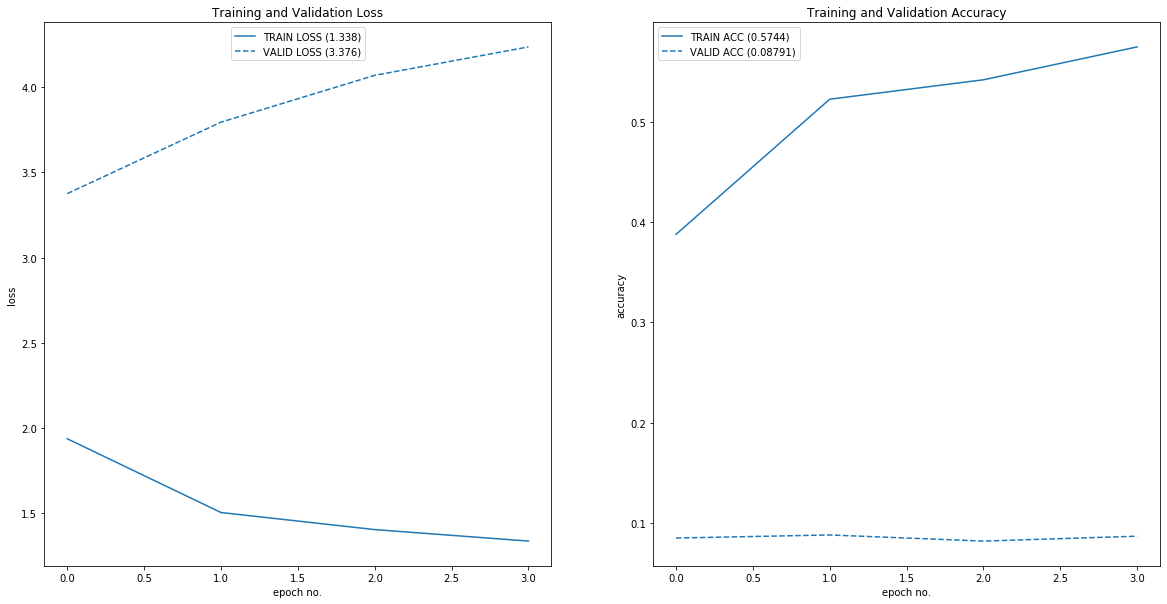

mean: tensor([0.5767, 0.4626, 0.3468]), std: tensor([0.2383, 0.2463, 0.2465])


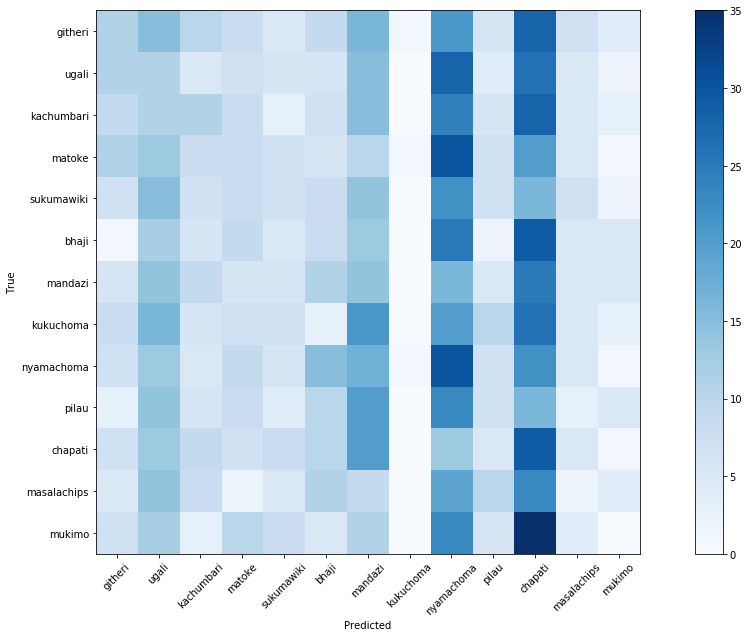

In [21]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

from sklearn.metrics import confusion_matrix

train_loader, test_loader = get_data(
        batch_size=train_config.batch_size,
        data_root=train_config.data_root,
        num_workers=train_config.num_workers,
        data_augmentation=True
    )

model.eval()

truelabels = []
predictions = []

classes = classesArray

for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

Share your tensorboard scalars logs link in this section. You can also share (not mandatory) your GitHub link if you have pushed this project in GitHub. 

For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

https://github.com/alanhaugen/pytorch-opencv-course-classification

[Find Project2 logs here](https://tensorboard.dev/experiment/OsVTLFkyQvuyolVgOwkLrQ/).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

https://www.kaggle.com/alanhaugen